In [1]:
import re
import pathlib as pl
import tomllib
import colorsys
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from functools import cached_property
from ast import literal_eval

from common.project import Project
from scatterplots import hr, load_tsv_file, load_txt, extract_tenn2_data
from novel_swarms.yaml import safe_load

In [9]:
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12
# matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.dpi'] = 300

In [2]:
def yaml_safe_load(path):
    with open(path, 'r') as f:
        return safe_load(f)


class Run(Project):
    def __init__(self, path, name=None):
        super().__init__(path, name)

        self.artifacts = self.root / 'artifacts'

        self.env = yaml_safe_load(self.artifacts / 'env.yaml')
        self.experiment = yaml_safe_load(self.artifacts / 'experiment.yaml')
        self.evolver = yaml_safe_load(self.artifacts / 'evolver.yaml')

    @cached_property
    def fitness_df(self):
        data = load_tsv_file(self.popfit_path)
        df = pd.DataFrame(data).T
        df.index = ('time', 'epoch', 'fitnesses')
        df = df.T
        df['time'] = df['time'].astype(float)
        df['epoch'] = df['epoch'].astype(int)
        df['fitnesses'] = df['fitnesses'].apply(eval)
        return df

In [3]:
folder = pl.Path('~/250108').expanduser()

projects = [Run(p) for p in folder.iterdir() if p.is_dir()]

In [4]:
fitnesses_per_run = [max(p.fitness_df['fitnesses'], default=0) for p in projects]
fitnesses_per_epoch = list(zip(*fitnesses_per_run))
# epoch_idxs = range(len(fitnesses_per_run[0]))

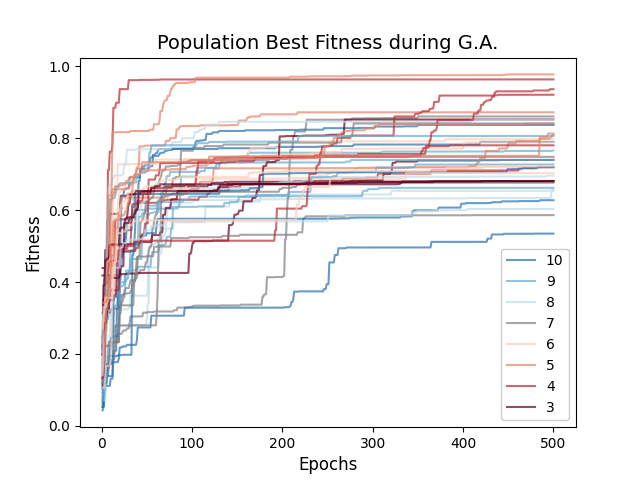

In [ ]:
fig, ax = plt.subplots(1, 1)
ax: plt.Axes

for p in projects:
    best_fitness_per_epoch = p.fitness_df['fitnesses'].apply(max)
    n_robots = p.env['spawners'][0]['n']
    color = cm.RdBu((n_robots - 3)/8) if n_robots != 7 else 'gray'
    ax.plot(p.fitness_df['epoch'], best_fitness_per_epoch, alpha=0.7, c=color, label=n_robots)

plt.xlabel("Epochs")
plt.ylabel("Fitness")
plt.title("Population Best Fitness during G.A. for N agents")
# make legend of unique labels, sorted by label
d = {int(label): handle for handle, label in zip(*ax.get_legend_handles_labels())}
labels = sorted(d.keys())[::-1]
handles = [d[label] for label in labels]
ax.legend(handles, labels, loc='lower right', framealpha=1.0)
%matplotlib widget
plt.show()
